In [ ]:
%pip install pandas librosa numpy tensorflow scikit-learn matplotlib seaborn

Preprocessing with Noise, Pitch, and Time Stretching...


C:\Users\avira\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
104/104 ━━━━━━━━━━━━━━━━━━━━ 49s 461ms/step - accuracy: 0.3145 - loss: 1.8772 - val_accuracy: 0.2174 - val_loss: 1.9828 - learning_rate: 0.0010
Epoch 2/60
104/104 ━━━━━━━━━━━━━━━━━━━━ 51s 495ms/step - accuracy: 0.4186 - loss: 1.6180 - val_accuracy: 0.2799 - val_loss: 2.2291 - learning_rate: 0.0010
Epoch 3/60
104/104 ━━━━━━━━━━━━━━━━━━━━ 51s 486ms/step - accuracy: 0.4725 - loss: 1.4667 - val_accuracy: 0.2690 - val_loss: 2.7334 - learning_rate: 0.0010
Epoch 4/60
104/104 ━━━━━━━━━━━━━━━━━━━━ 52s 503ms/step - accuracy: 0.5233 - loss: 1.3375 - val_accuracy: 0.2174 - val_loss: 2.6215 - learning_rate: 0.0010
Epoch 5/60
104/104 ━━━━━━━━━━━━━━━━━━━━ 52s 497ms/step - accuracy: 0.5602 - loss: 1.2500 - val_accuracy: 0.3478 - val_loss: 2.0262 - learning_rate: 0.0010
Epoch 6/60
104/104 ━━━━━━━━━━━━━━━━━━━━ 52s 496ms/step - accuracy: 0.6153 - loss: 1.1130 - val_accuracy: 0.4185 - val_loss: 1.7814 - learning_rate: 5.0000e-04
Epoch 7/60
104/104 ━━━━━━━━━━━━━━━━━━━━ 51s 495ms/step - accuracy:

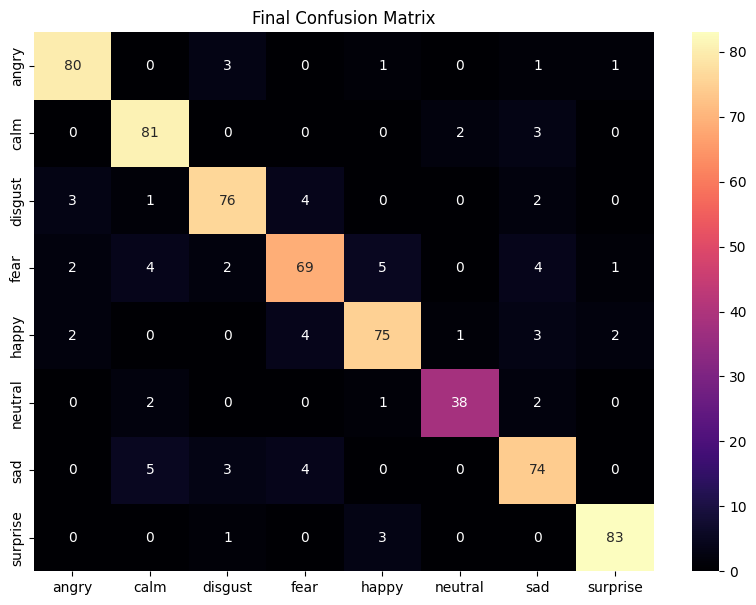


 Pitch Bias Results 
Male Accuracy: 87.96%
Female Accuracy: 89.81%


In [10]:
import os
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

data_path = r'C:\Users\avira\Downloads\archive' 
raw_metadata = []

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith('.wav'):
            parts = file.split('-')
            emotion = int(parts[2])
            actor = int(parts[6].split('.')[0])
            gender = "female" if actor % 2 == 0 else "male" 
            raw_metadata.append([emotion, gender, os.path.join(root, file)])

df = pd.DataFrame(raw_metadata, columns=['Emotion', 'Gender', 'Path'])
emotion_map = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}
df['Emotion'] = df['Emotion'].replace(emotion_map)

def extract_features(path, mode=None):
    y, sr = librosa.load(path, duration=3, offset=0.5)
    y, _ = librosa.effects.trim(y, top_db=30)
    
    if mode == 'noise_pitch':
        noise = 0.005 * np.random.uniform() * np.amax(y)
        y = y + noise * np.random.normal(size=y.shape[0])
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=0.7)
    
    elif mode == 'stretch':
        rate = np.random.uniform(0.8, 1.2)
        y = librosa.effects.time_stretch(y, rate=rate)
    
    spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_spec = librosa.power_to_db(spec, ref=np.max)
    
    if log_spec.shape[1] < 128:
        log_spec = np.pad(log_spec, ((0,0), (0, 128 - log_spec.shape[1])), mode='constant')
    return log_spec[:, :128]

print("Preprocessing with Noise, Pitch, and Time Stretching...")
X_orig = np.array([extract_features(p, mode=None) for p in df['Path']])
X_aug1 = np.array([extract_features(p, mode='noise_pitch') for p in df['Path']])
X_aug2 = np.array([extract_features(p, mode='stretch') for p in df['Path']])

X = np.concatenate([X_orig, X_aug1, X_aug2])
X = X.reshape(X.shape[0], 128, 128, 1)

y_labels = pd.concat([df['Emotion'], df['Emotion'], df['Emotion']])
g_labels = pd.concat([df['Gender'], df['Gender'], df['Gender']])

lb = LabelEncoder()
y_encoded = lb.fit_transform(y_labels)
y_cat = to_categorical(y_encoded)

neutral_index = list(lb.classes_).index('neutral')

X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(
    X, y_cat, g_labels, test_size=0.15, stratify=y_labels, random_state=42)

model = Sequential([
    Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(128,128,1)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(256, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(8, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

class_weights = {i: 1.0 for i in range(len(lb.classes_))}
class_weights[neutral_index] = 2.0 

callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
]

history = model.fit(X_train, y_train, validation_split=0.1, epochs=60, 
                    batch_size=32, callbacks=callbacks, class_weight=class_weights)

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nFinal Classification Report:")
print(classification_report(y_true, y_pred, target_names=lb.classes_))

plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', 
            xticklabels=lb.classes_, yticklabels=lb.classes_, cmap='magma')
plt.title('Final Confusion Matrix')
plt.show()

print("\n Pitch Bias Results ")
for gender in ['male', 'female']:
    mask = (g_test.values == gender)
    acc = np.mean(y_pred[mask] == y_true[mask])
    print(f"{gender.capitalize()} Accuracy: {acc*100:.2f}%")

model.save('2025a7ps0603p_model.keras')